---
---

# Introduction to DeepInsight - Decoding position, speed and head direction from tetrode CA1 recordings

This notebook stands as an example of how to use DeepInsight v0.5 on tetrode data and can be used as a guide on how to adapt it to your own datasets. All methods are stored in the deepinsight library and can be called directly or in their respective submodules. A typical workflow might look like the following: 
- Load your dataset into a format which can be directly indexed (numpy array or pointer to a file on disk)
- Preprocess the raw data (wavelet transformation)
- Preprocess your outputs (the variable you want to decode)
- Define appropriate loss functions for your output and train the model 
- Predict performance across all cross validated models
- Visualize influence of different input frequencies on model output


In [17]:
# Import DeepInsight
import deepinsight
# Choose GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


---
---
Here you can define the paths to your raw data files, and create file names for the preprocessed HDF5 datasets.

The data we use here is usually relatively large in its raw format. Running it through the next lines takes roughly 24 hours for a 40 minute recording.

We provide a preprocess file to play with the code. See next cell

In [18]:
# Define base paths
base_path = './example_data/'
fp_raw_file = base_path + 'experiment_1.nwb' # This is your raw file
fp_deepinsight = base_path + 'processed_R2478.h5' # This will be the processed HDF5 file

if os.path.exists(fp_raw_file):
    # Load data 
    (raw_data,
     raw_timestamps,
     output,
     output_timestamps,
     info) = deepinsight.util.tetrode.read_tetrode_data(fp_raw_file)
    # Transform raw data to frequency domain
    deepinsight.preprocess.preprocess_input(fp_deepinsight, raw_data, sampling_rate=info['sampling_rate'],
                                            channels=info['channels'])
    # Prepare outputs
    deepinsight.util.tetrode.preprocess_output(fp_deepinsight, raw_timestamps, output,
                                               output_timestamps, sampling_rate=info['sampling_rate'])

---
---
The above steps create a HDF5 file with all important data for training the model.

You can download the preprocessed dataset by running the following command

In [ ]:
!wget https://ndownloader.figshare.com/files/20150468 -O ./example_data/processed_R2478.h5

---
---
Now we can train the model. 

The following command uses 5 cross validations to train the models and stores weights in HDF5 files

In [ ]:
# Define loss functions and train model
loss_functions = {'position' : 'euclidean_loss', 
                  'head_direction' : 'cyclical_mae_rad', 
                  'speed' : 'mae'}
loss_weights = {'position' : 1, 
                'head_direction' : 25, 
                'speed' : 2}
deepinsight.train.run_from_path(fp_deepinsight, loss_functions, loss_weights)

In [ ]:
# Get loss and shuffled loss for influence plot, both is also stored back to HDF5 file
losses, output_predictions, indices = deepinsight.analyse.get_model_loss(fp_deepinsight,
                                                                         stepsize=10)
shuffled_losses = deepinsight.analyse.get_shuffled_model_loss(fp_deepinsight, axis=1,
                                                              stepsize=10)

---
---
Above line calculates the loss and shuffled loss across the full experiment and writes it back to the HDF5 file.

Below command visualizes the influence across different frequency bands for all samples

Note that Figure 3 in the manuscript shows influence across animals, while this plot shows the influence for one animal across the experiment

<IPython.core.display.Javascript object>


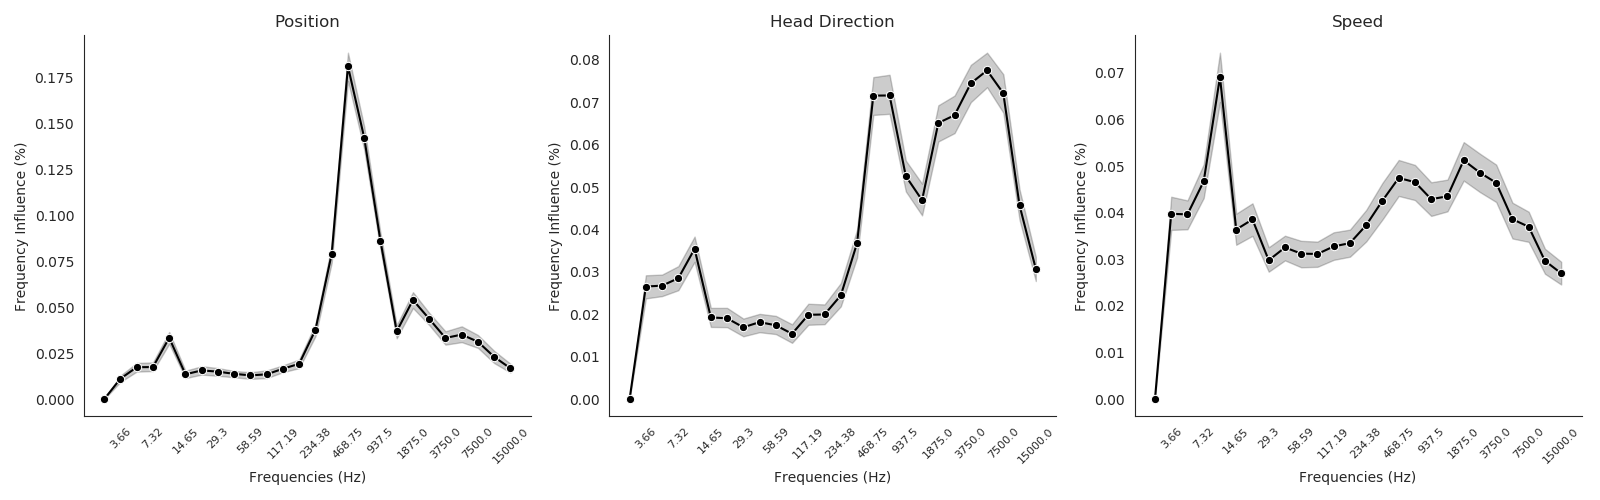

In [23]:
# Plot influence across behaviours
deepinsight.visualize.plot_residuals(fp_deepinsight, frequency_spacing=2,
                                     output_names=['Position', 'Head Direction', 'Speed'])

---
---